### Bar plot of Figure of Merit for WFD

- [time gaps](#time-gaps)
- [depth](#depth)
- [footprint](#footprint)
- [proper motion](#proper-motion)
- [all](#all)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [10]:
plt.style.use('seaborn')
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.facecolor'] = "w"


In [11]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
cols_all = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

cols_same = [ 'uu',  'gg',  'rr',  'ii',  'zz',  'yy']

cols_diff = ['ug', 'ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy']


In [12]:
def scale(arr, mode=0):
    """scale array by max"""
    newarr = arr / arr.max()
    if mode==1:
        # scale to 0-1
        newarr = (arr - arr.min()) / (arr.max()-arr.min())
    return newarr

def get_family(df):
    """get family of opsim"""
    
    return df['db'].split('_')[0]


In [22]:
'db' in df_new.columns

True

In [95]:
def get_df_norm(df=[], cols=['u'], fomcsv = 'df_tgapsFoM_GP.csv', mode=0):
    """
    Input: dataframe or csvfile
    return normalized dataframe
    cols: columns to normalize
    """
    
    if len(df)!=0:
        df_fom = df.copy()
    else:
        df_fom = pd.read_csv(fomcsv)
    
    if 'db' not in df_fom.columns:
        df_fom['db'] = dblist_all
        
    # scale fom table to 0 and 1
    if 'prop' in df_fom.columns:
        df_new = df_fom[ ['db', 'prop'] ].copy()
    else:
        df_new = df_fom[ ['db'] ].copy()
    
    for col in cols:
        # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
        df_new[col] = scale(df_fom[col], mode=mode) 
        
    df_new['db'] = df_new['db'].apply(lambda x: x.replace(".db", "") )

    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs", "") )
    
    
    df_new['family'] = df_new.apply(get_family, axis=1)
    
    return df_new



In [13]:
# get the name of all opsim dbs 
import os
import glob

workpath = os.getcwd()
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases
os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps'
os.chdir(workpath) # change back to work directory
dblist_all.sort()


In [81]:
#dblist_all

In [14]:
def plot_barh(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", **kwargs):
    """barh plot of FoM"""

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    
    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')


def get_mycmap(pairs='diff'):
    """discrete colormap for filter pairs"""
    import numpy as np
    import matplotlib.colors as mcolors
    
    # colors in total
    # combine them and build a new colormap

    thecbases = [plt.cm.Blues,
                 plt.cm.Greens,
                 plt.cm.Purples,
                 plt.cm.Reds,
                 plt.cm.YlOrBr,
                 (240./255,230./255,140./255, 1.),
                ]

    grad = [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    
    #thecmaps = {'diff': , [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    #                'same':[thecbases[i](np.linspace(0, 1, 7-i)[-3 if i < 2 else -2]) 
    #                     for i in range(5)] + [thecbases[5]]}
    
    thecmaps = {'diff': [ grad[i] [ 1:6 - i ] for i in range(5) ] ,
                'same':[ grad[i] [ 1 if i!=5 else 0 ] for i in range(5) ] + [thecbases[5]]}
    
    colors = np.vstack( [c for c in thecmaps[pairs]] )
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
            
    #plt.pcolor(data, cmap=mymap)
    #plt.colorbar()
    #plt.show()
    return mymap



### time gaps

In [63]:
fomcsv = './data_v1_5/df_tgapsFoM_wfd.csv'
df_norm = get_df_norm(fomcsv = fomcsv, cols=cols_all)


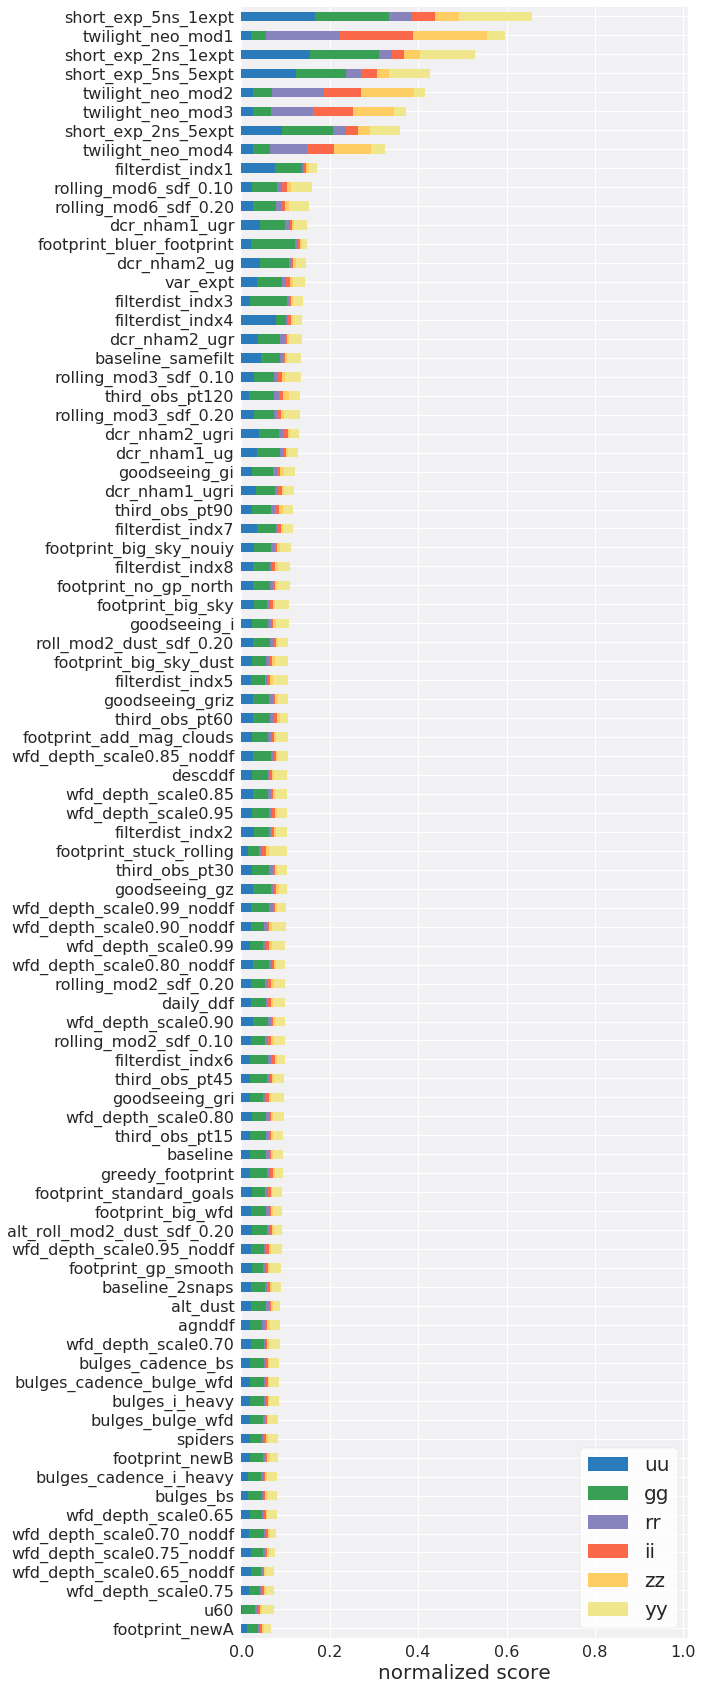

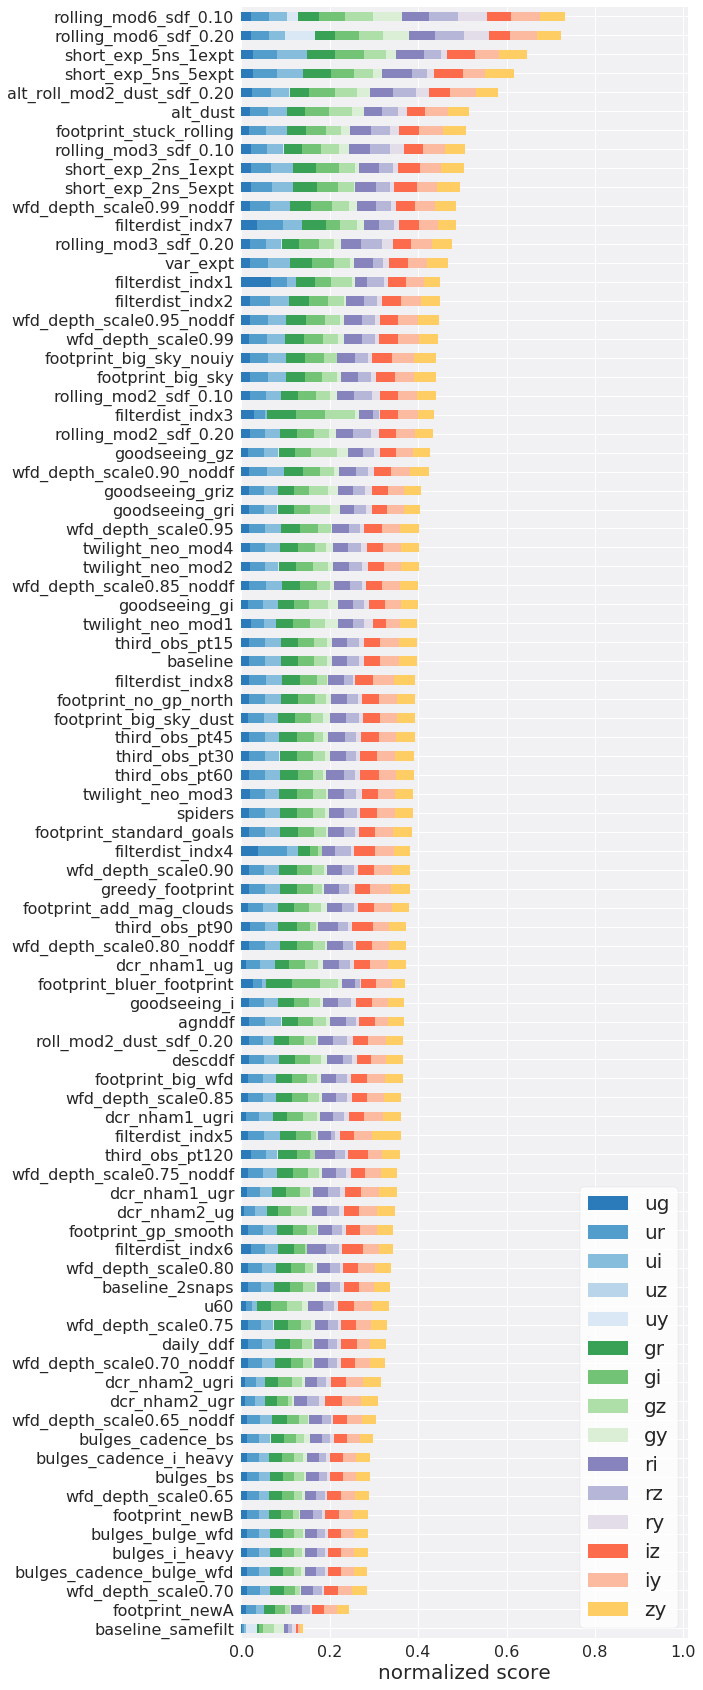

In [64]:
plot_barh(df_norm, colon=cols_same, byfamily=False, savefig='figures/barh_tgaps_same_wfd.pdf', colormap=get_mycmap(pairs='same')) 
plot_barh(df_norm, colon=cols_diff, byfamily=False, savefig='figures/barh_tgaps_diff_wfd.pdf', colormap=get_mycmap(pairs='diff') ) 



### depth

In [65]:
fomcsv = './data_v1_5/df_depth_wfd.csv'
df_norm = get_df_norm(fomcsv = fomcsv, cols=filters, mode=1)


In [36]:
df_norm.head()

,db,u,g,r,i,z,y,family
0,agnddf,0.791325,0.877899,0.947105,0.870985,0.915078,0.857861,agnddf
1,alt_dust,0.774883,0.820540,0.828575,0.771955,0.827502,0.494276,alt
2,alt_roll_mod2_dust_sdf_0.20,0.773044,0.790706,0.705284,0.662905,0.753673,0.221650,alt
3,baseline_2snaps,0.721116,0.778687,0.859178,0.817376,0.897554,0.803293,baseline
4,baseline_samefilt,0.796483,0.814043,0.826508,0.875032,0.826138,0.755444,baseline


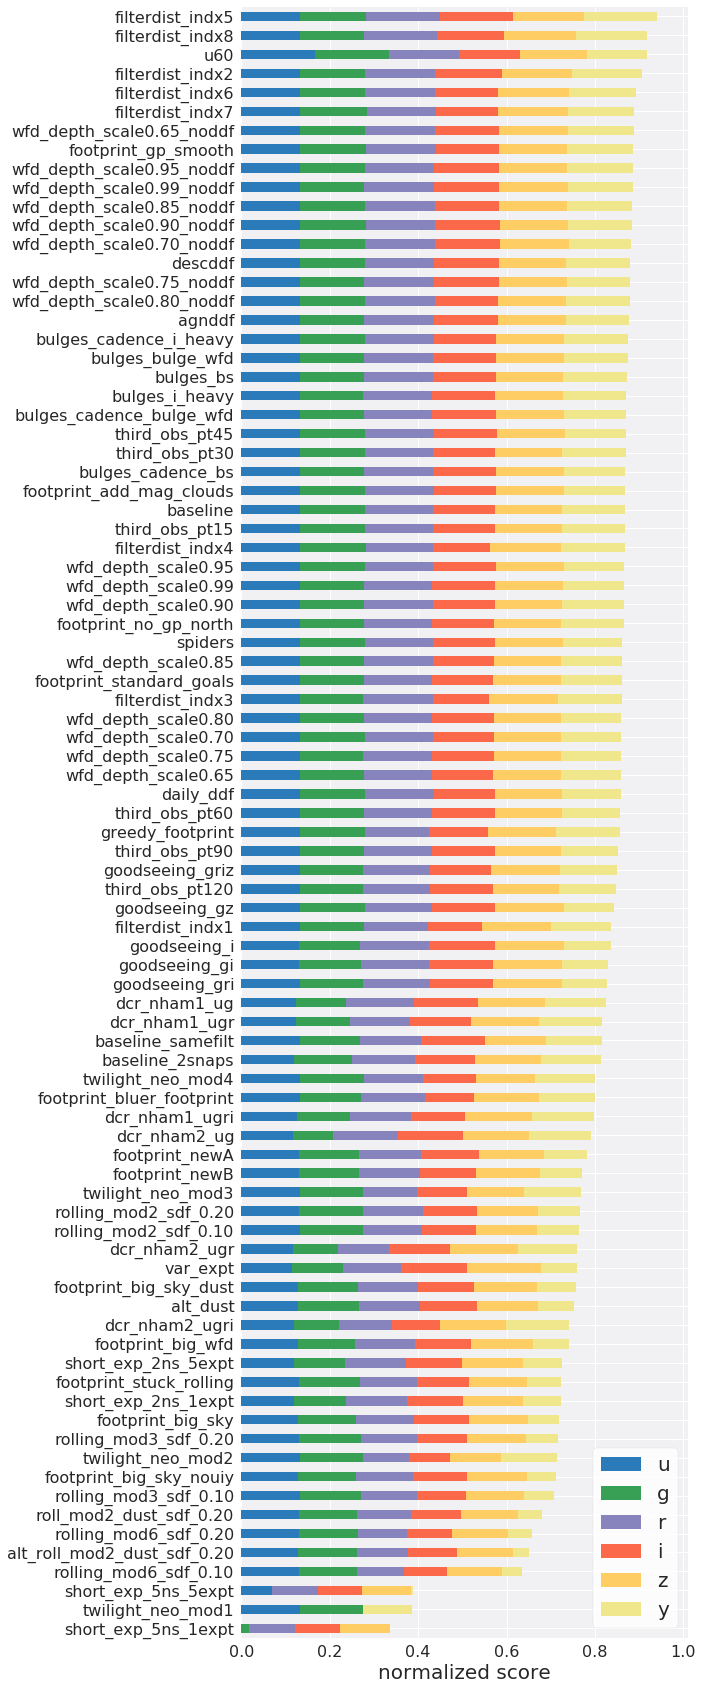

In [66]:
plot_barh(df_norm, colon=filters, byfamily=False, savefig='figures/barh_depth_wfd.pdf', colormap=get_mycmap(pairs='same')) 



### footprint

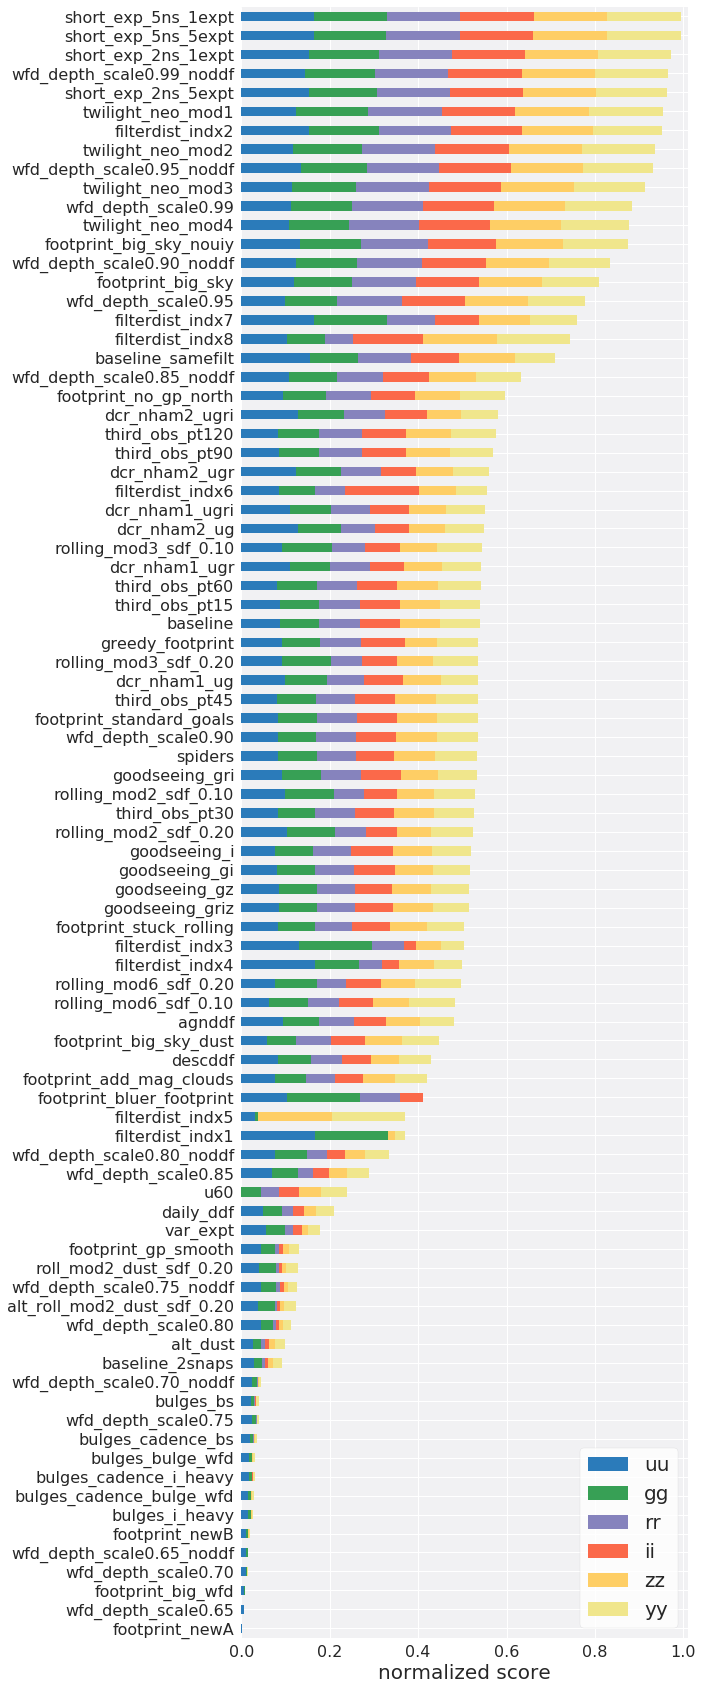

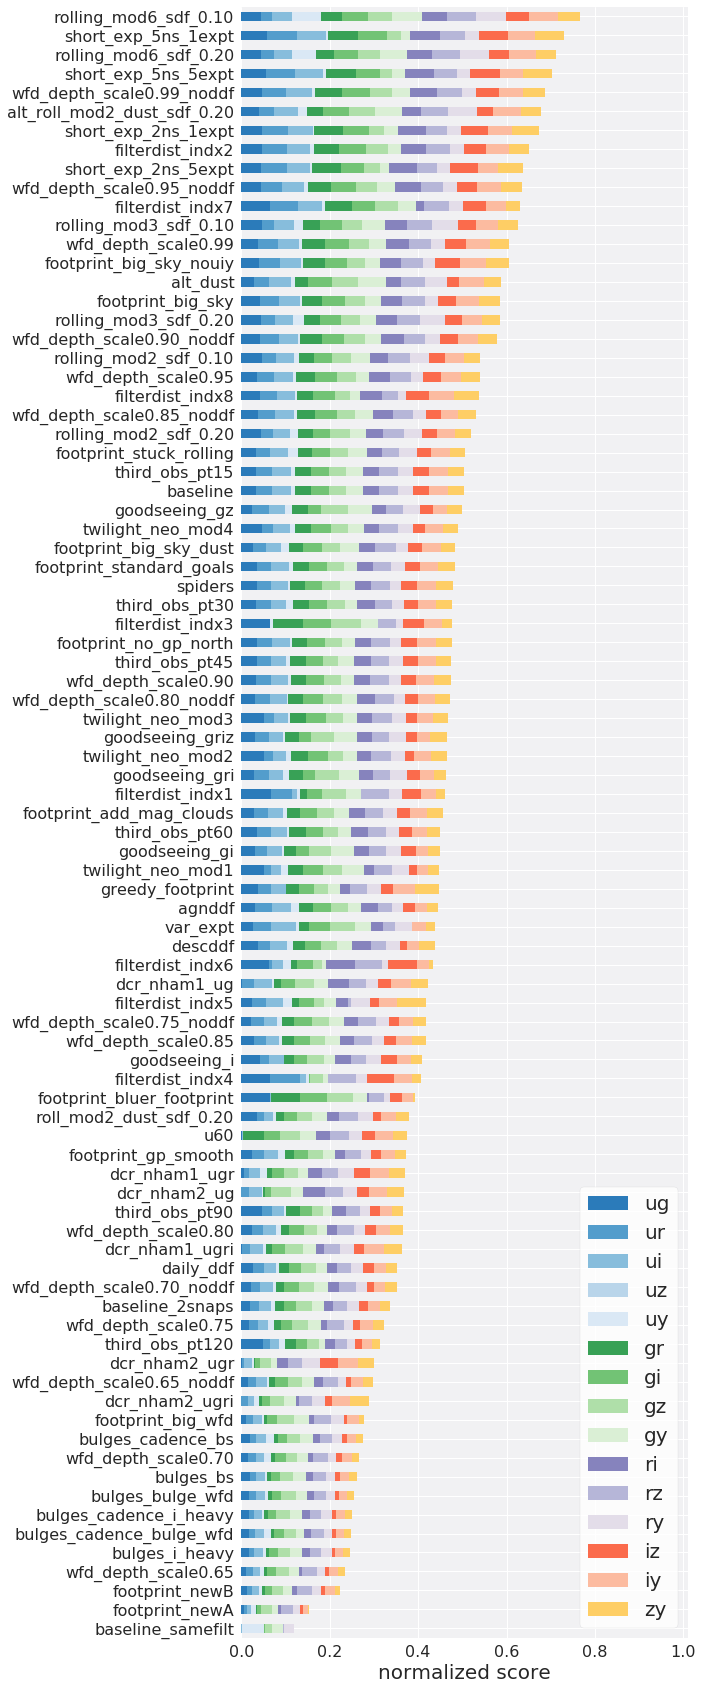

In [67]:
fomcsv = './data_v1_5/df_Nfields_wfd.csv'
df_norm = get_df_norm(fomcsv = fomcsv, cols=cols_all)

plot_barh(df_norm, colon=cols_same, byfamily=False, savefig='figures/barh_nfields_same_wfd.pdf', colormap=get_mycmap(pairs='same')) 
plot_barh(df_norm, colon=cols_diff, byfamily=False, savefig='figures/barh_nfields_diff_wfd.pdf', colormap=get_mycmap(pairs='diff') ) 



### star density

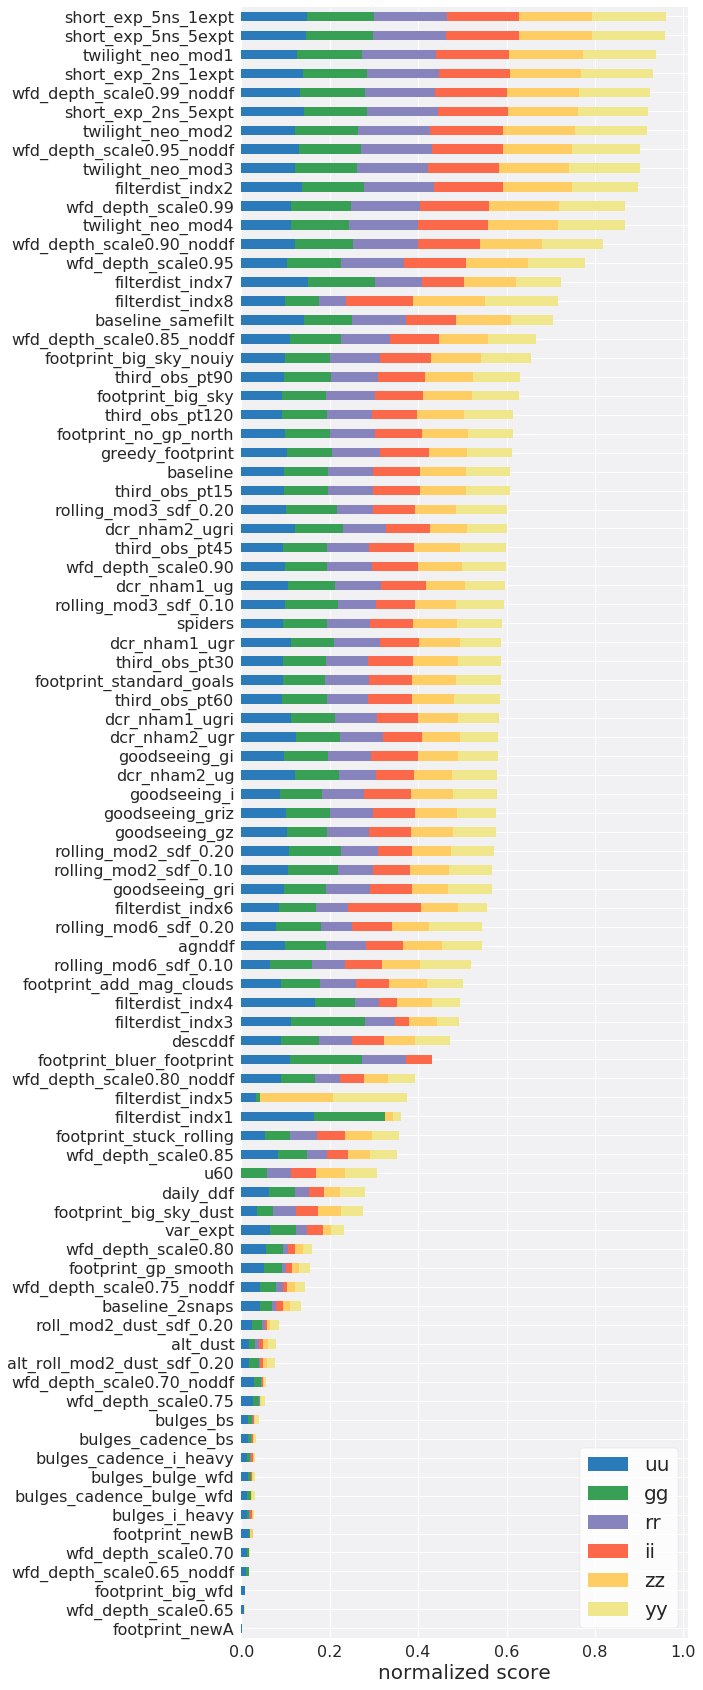

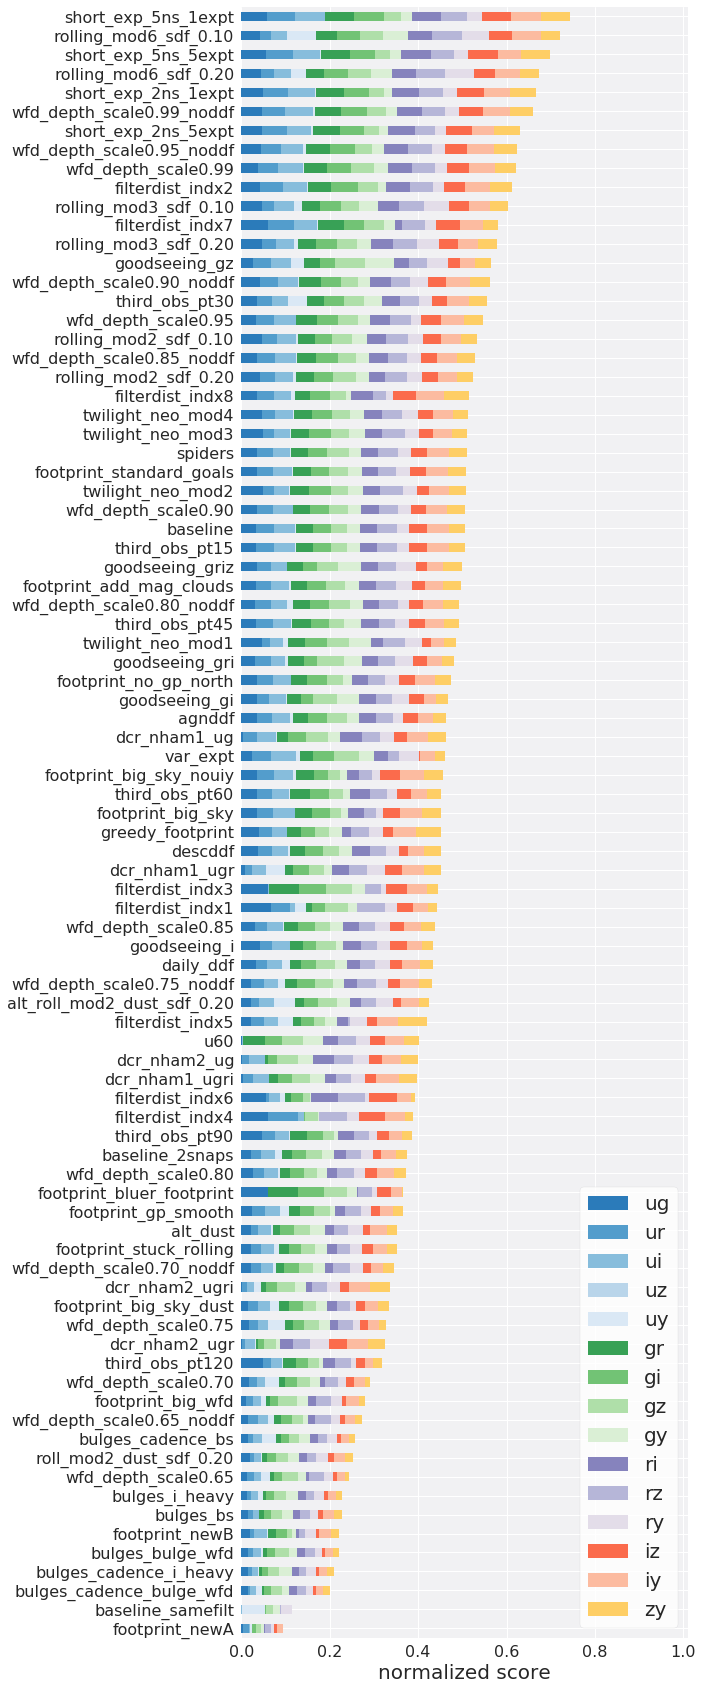

In [100]:
fomcsv = './data_v1_5/df_Nstars_wfd.csv'
df_norm = get_df_norm(fomcsv = fomcsv, cols=cols_all)

plot_barh(df_norm, colon=cols_same, byfamily=False, savefig='figures/barh_nstars_same_wfd.pdf', colormap=get_mycmap(pairs='same')) 
plot_barh(df_norm, colon=cols_diff, byfamily=False, savefig='figures/barh_nstars_diff_wfd.pdf', colormap=get_mycmap(pairs='diff') ) 



### proper motion

### all

In [69]:
fomcsv = './data_v1_5/df_radar_wfd.csv'
df_fom = pd.read_csv(fomcsv)
df_fom['family'] = df_fom.apply(get_family, axis=1)

df_fom.head()

,db,FoM_tgaps_same,FoM_tgaps_diff,FoM_EG,FoM_Gal,FoM_depth,family
0,agnddf_v1.5_10yrs,0.132988,0.503818,0.564762,0.587077,0.931742,agnddf
1,alt_dust_v1.5_10yrs,0.133044,0.703636,0.554701,0.304529,0.800220,alt
2,alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs,0.138956,0.795575,0.644424,0.333097,0.692088,alt
3,baseline_2snaps_v1.5_10yrs,0.135375,0.461125,0.330473,0.341037,0.863893,baseline
4,baseline_samefilt_v1.5_10yrs,0.206479,0.190582,0.357034,0.312804,0.866805,baseline


In [70]:
FoMvars = ['FoM_tgaps_same','FoM_tgaps_diff', 'FoM_depth', 'FoM_EG', 'FoM_Gal',]


In [71]:
import matplotlib.colors as mcolors
colors = plt.cm.tab10( np.linspace(0., 1, 10) )[:5]
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)


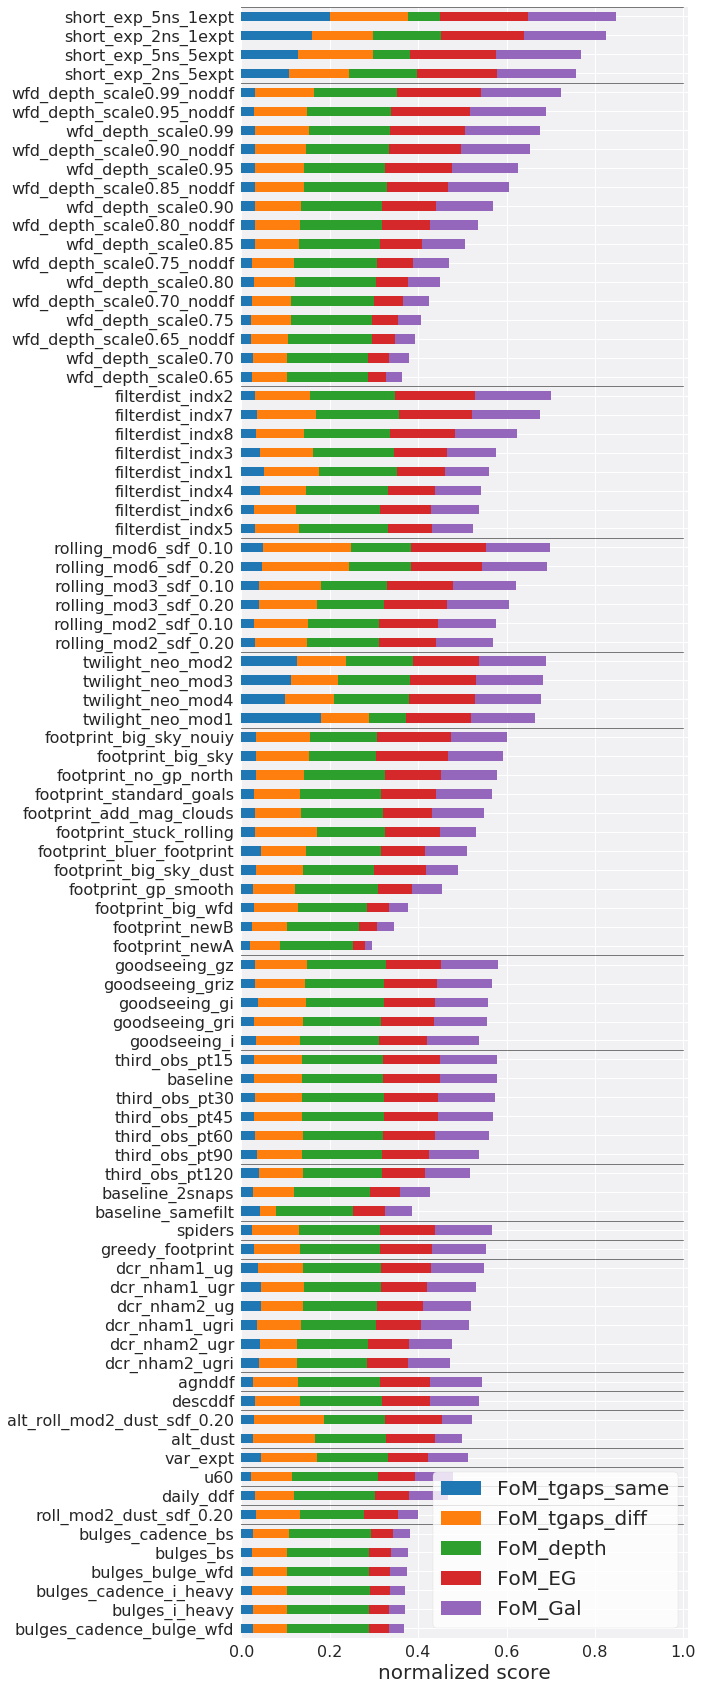

In [99]:
fomcsv = './data_v1_5/df_radar_wfd.csv'
#fomcsv = './data_v1_5/df_Nstars_wfd.csv'

df_norm = get_df_norm(fomcsv=fomcsv , cols=FoMvars)


plot_barh(df_norm, colon=FoMvars, byfamily=True, savefig='figures/barh_family_wfd.pdf', colormap=mymap ) 


In [80]:
df_norm

,db,uu,ug,ur,ui,uz,uy,gg,gr,gi,...,ri,rz,ry,ii,iz,iy,zz,zy,yy,family
0,agnddf,0.592057,0.526084,0.508797,0.602379,NaN,0.117702,0.561991,0.515434,0.644430,...,0.572204,0.599908,0.343128,0.501941,0.505576,0.505165,0.538609,0.449211,0.542382,agnddf
1,alt_dust,0.098307,0.321668,0.256531,0.433918,NaN,0.052870,0.085453,0.260774,0.451196,...,0.315299,0.481493,0.514684,0.057900,0.219881,0.564405,0.062881,0.364243,0.107720,alt
2,alt_roll_mod2_dust_sdf_0.20,0.108144,0.330518,0.272088,0.507448,NaN,0.717493,0.132907,0.308487,0.481991,...,0.362327,0.525210,0.558698,0.040580,0.282072,0.596789,0.054314,0.369356,0.105488,alt
3,baseline_2snaps,0.247189,0.323339,0.330832,0.498160,NaN,0.243926,0.164163,0.337281,0.452878,...,0.397121,0.501257,0.399894,0.088069,0.291205,0.489545,0.097253,0.369142,0.145634,baseline
4,baseline_samefilt,0.844221,0.000000,0.000000,0.036675,NaN,0.773376,0.656691,0.000000,0.017588,...,0.000000,0.026377,0.374299,0.678146,0.000000,0.000000,0.749427,0.000000,0.575517,baseline
5,baseline,0.578589,0.511878,0.580527,0.731309,NaN,0.028270,0.595024,0.575683,0.609483,...,0.599430,0.664176,0.405528,0.632414,0.622617,0.737401,0.625631,0.533826,0.599755,baseline
6,bulges_bs,0.091341,0.218326,0.173494,0.199222,NaN,0.014777,0.052654,0.162729,0.252176,...,0.240502,0.339064,0.267325,0.016742,0.166458,0.369325,0.017140,0.278216,0.055302,bulges
7,bulges_bulge_wfd,0.084196,0.223006,0.186346,0.252353,NaN,0.069041,0.042847,0.126566,0.276425,...,0.264833,0.340830,0.249552,0.006251,0.096107,0.247526,0.014067,0.207581,0.033343,bulges
8,bulges_cadence_bs,0.083983,0.228339,0.161087,0.306863,NaN,0.497374,0.046723,0.155062,0.270626,...,0.273727,0.311809,0.328252,0.010168,0.126912,0.278842,0.015532,0.208876,0.025001,bulges
9,bulges_cadence_bulge_wfd,0.078079,0.211252,0.098774,0.184632,NaN,0.196744,0.051208,0.085392,0.242267,...,0.262068,0.303788,0.248105,0.005249,0.092764,0.237361,0.006387,0.216426,0.039863,bulges
